### Profiling Comparion Flash multi head Attention (1) vs Standart Multi head attention

- Installation

In [ ]:
!pip install torch numpy pandas matplotlib flash_attn

- Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import gc
from torch.profiler import (
    profile, record_function, ProfilerActivity, schedule, tensorboard_trace_handler
)

from flash_attn import flash_attn_func, flash_attn_qkvpacked_func
from flash_attn.modules.mha import MHA

# Set random seed for reproducibility
torch.manual_seed(42)

- Attention Classes

In [ ]:
class StandardSelfAttention(nn.Module):
    """Standard self-attention implementation for profiling comparison."""
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim, bias=True)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=True)
        
        self.scale = self.head_dim ** -0.5
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # QKV projection
        qkv = self.qkv_proj(x)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, batch_size, num_heads, seq_len, head_dim]
        
        # Separate Q, K, V
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Scaled dot-product attention
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn_probs = F.softmax(attn_weights, dim=-1)
        
        # Apply attention weights to values
        attn_output = torch.matmul(attn_probs, v)
        
        # Reshape and project back
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        attn_output = attn_output.reshape(batch_size, seq_len, self.embed_dim)
        attn_output = self.out_proj(attn_output)
        
        return attn_output

class FlashSelfAttention(nn.Module):
    """FlashAttention-based self-attention implementation for profiling comparison."""
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        # Use FlashMHA module for FlashAttention
        self.flash_mha = MHA(
            embed_dim=embed_dim,
            num_heads=num_heads,
            causal=False,
            device="cuda"
        )

    def forward(self, x):
        return self.flash_mha(x)[0]

- Profiling and results

CUDA available: True
GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
CUDA capability: (8, 6)
Running performance comparison...
Profiling batch_size=1, seq_len=128
Profiling batch_size=1, seq_len=512
Profiling batch_size=1, seq_len=1024
Profiling batch_size=1, seq_len=2048
Profiling batch_size=4, seq_len=128
Profiling batch_size=4, seq_len=512
Profiling batch_size=4, seq_len=1024
Profiling batch_size=4, seq_len=2048
Profiling batch_size=8, seq_len=128
Profiling batch_size=8, seq_len=512
Profiling batch_size=8, seq_len=1024
Profiling batch_size=8, seq_len=2048
Results saved to flashattention_results.csv
Plotting performance comparison...


/tmp/ipykernel_25432/2359072230.py:279: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(batch_seq_labels, rotation=45)
/tmp/ipykernel_25432/2359072230.py:286: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(batch_seq_labels, rotation=45)


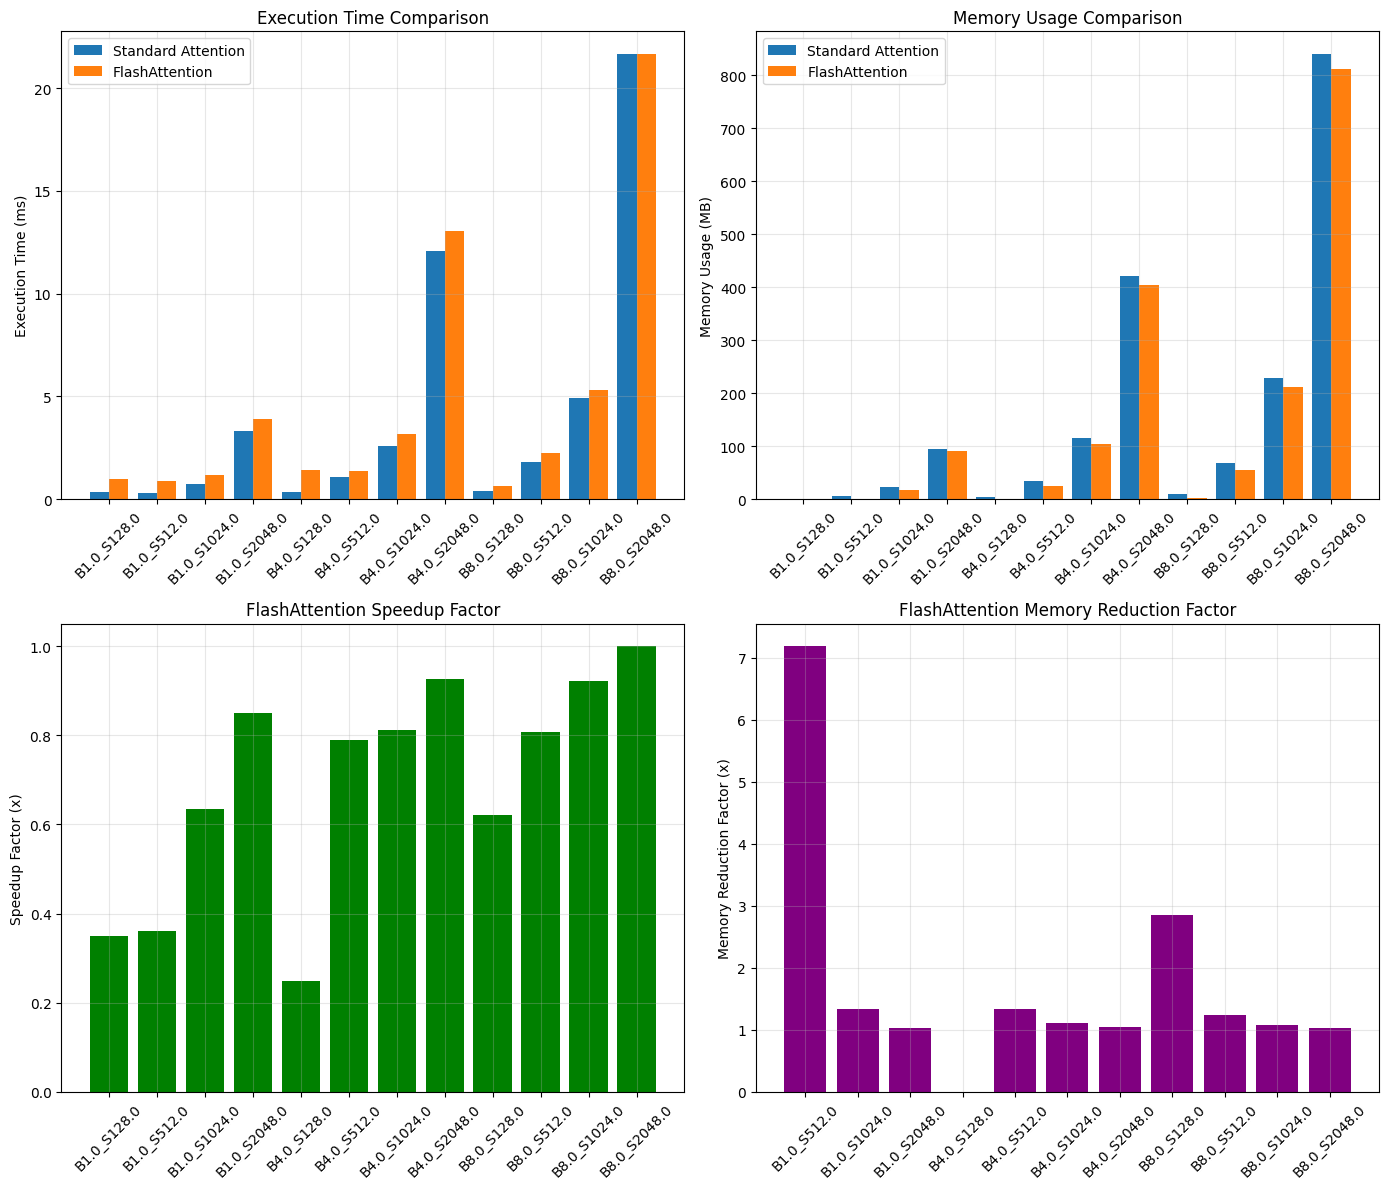

Running sequence length scaling test...
Testing sequence length: 128
Testing sequence length: 256
Testing sequence length: 512
Testing sequence length: 1024
Testing sequence length: 2048
Scaling results saved to flashattention_scaling_results.csv
Plotting sequence length scaling...


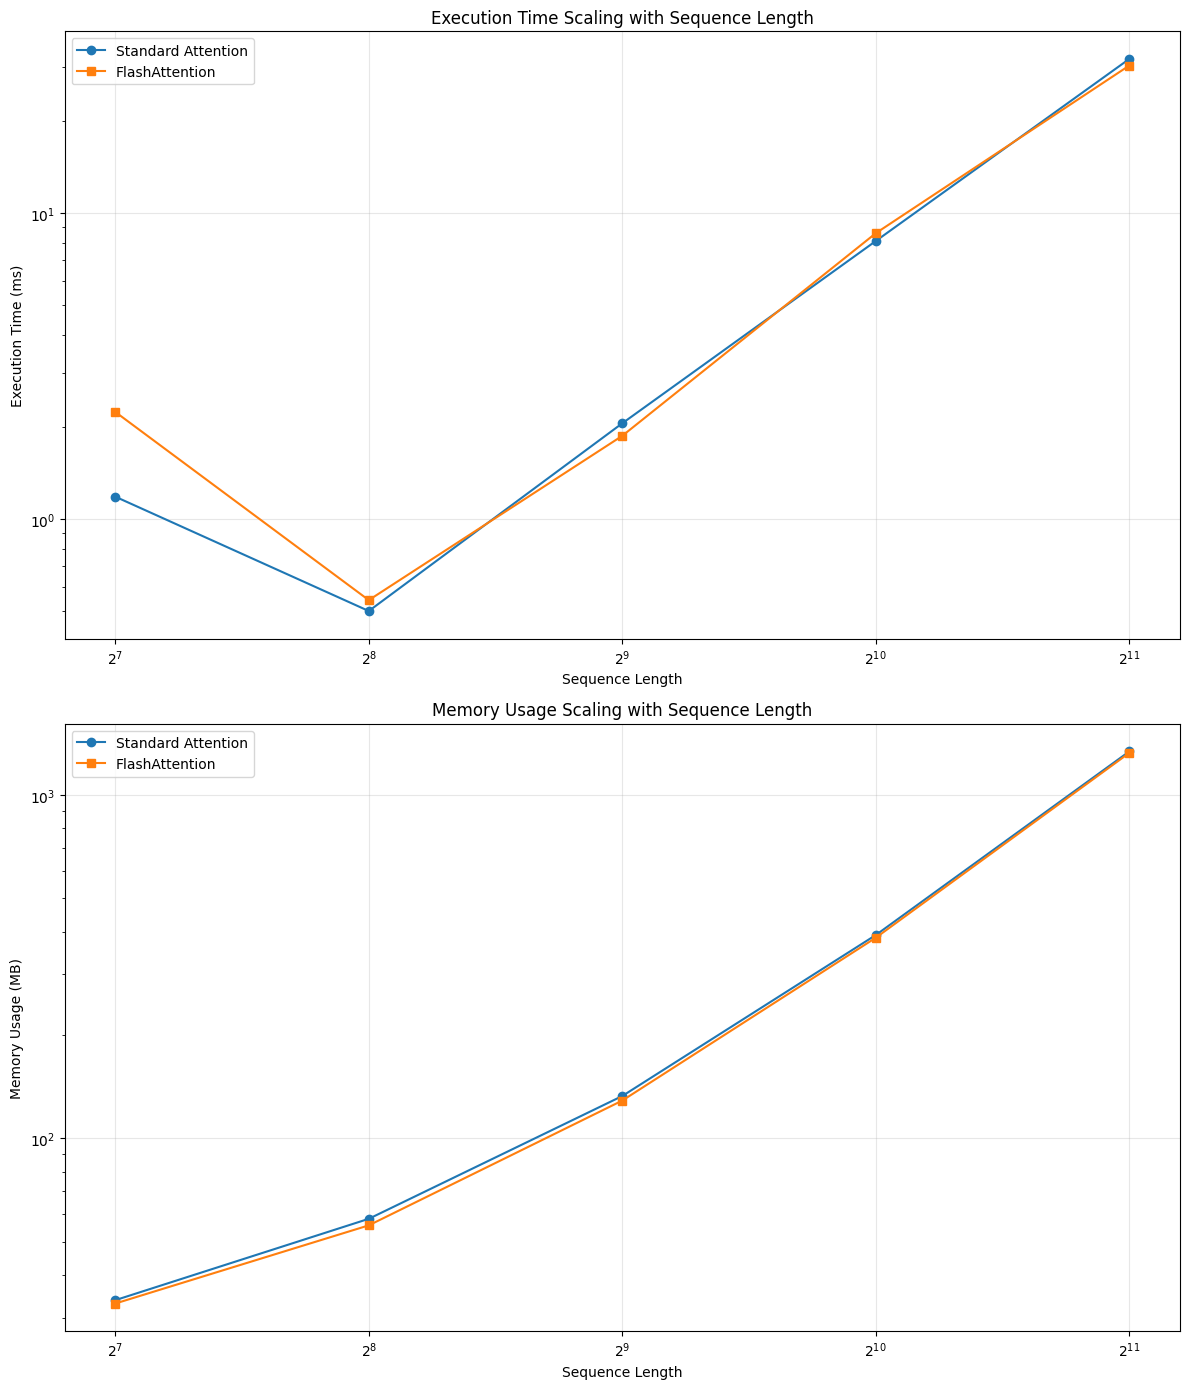

Running detailed profiling with torch.profiler...
Standard Attention Profiling:
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                          Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    standard_attention_forward        14.09%       1.641ms        41.29%       4.806ms       4.806ms           8 b           8 b      -5.96 Mb      -1.17 Gb             1            --  
                  aten::linear         0.64%      74.769us        22.05%       2.567ms       1.283ms           0 b           0 b      24.01 Mb           0 b             2 

[W418 11:22:37.373747242 CPUAllocator.cpp:245] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event


In [ ]:
def profile_attention_models(batch_sizes, seq_lengths, embed_dim=768, num_heads=12, warmup=3, repeats=5):
    """
    Profile and compare standard attention vs FlashAttention across different batch sizes
    and sequence lengths.
    
    Args:
        batch_sizes: List of batch sizes to test
        seq_lengths: List of sequence lengths to test
        embed_dim: Embedding dimension
        num_heads: Number of attention heads
        warmup: Number of warmup iterations
        repeats: Number of measurement iterations
    
    Returns:
        DataFrame with profiling results
    """
    results = []
    
    for batch_size in batch_sizes:
        for seq_len in seq_lengths:
            print(f"Profiling batch_size={batch_size}, seq_len={seq_len}")
            
            # Create input tensor
            x = torch.randn(batch_size, seq_len, embed_dim, device="cuda", dtype=torch.float16)
            
            # Initialize models
            standard_attn = StandardSelfAttention(embed_dim, num_heads).to("cuda").half()
            flash_attn = FlashSelfAttention(embed_dim, num_heads).to("cuda").half()
            
            # Warmup iterations
            for _ in range(warmup):
                _ = standard_attn(x)
                _ = flash_attn(x)
                torch.cuda.synchronize()
            
            # Measure standard attention
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.synchronize()
            standard_memory_before = torch.cuda.memory_allocated()
            
            standard_start = time.time()
            for _ in range(repeats):
                _ = standard_attn(x)
            torch.cuda.synchronize()
            standard_time = (time.time() - standard_start) / repeats
            
            standard_memory = torch.cuda.max_memory_allocated() - standard_memory_before
            
            # Clear cache
            del standard_attn
            torch.cuda.empty_cache()
            gc.collect()
            
            # Measure FlashAttention
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.synchronize()
            flash_memory_before = torch.cuda.memory_allocated()
            
            flash_start = time.time()
            for _ in range(repeats):
                _ = flash_attn(x)
            torch.cuda.synchronize()
            flash_time = (time.time() - flash_start) / repeats
            
            flash_memory = torch.cuda.max_memory_allocated() - flash_memory_before
            
            # Clear cache
            del flash_attn, x
            torch.cuda.empty_cache()
            gc.collect()
            
            # Record results
            results.append({
                "batch_size": batch_size,
                "seq_len": seq_len,
                "standard_time_ms": standard_time * 1000,
                "flash_time_ms": flash_time * 1000,
                "standard_memory_mb": standard_memory / (1024**2),
                "flash_memory_mb": flash_memory / (1024**2),
                "time_speedup": standard_time / flash_time,
                "memory_reduction": standard_memory / flash_memory if flash_memory > 0 else float('inf')
            })
    
    return pd.DataFrame(results)

def profile_with_torch_profiler(batch_size=8, seq_len=512, embed_dim=768, num_heads=12):
    """
    Use torch.profiler to get detailed profiling information for both models.
    
    Args:
        batch_size: Batch size to profile
        seq_len: Sequence length to profile
        embed_dim: Embedding dimension
        num_heads: Number of attention heads
    """
    # Create input tensor
    x = torch.randn(batch_size, seq_len, embed_dim, device="cuda", dtype=torch.float16)
    
    # Initialize models
    standard_attn = StandardSelfAttention(embed_dim, num_heads).to("cuda").half()
    flash_attn = FlashSelfAttention(embed_dim, num_heads).to("cuda").half()
    
    # Warmup
    for _ in range(3):
        _ = standard_attn(x)
        _ = flash_attn(x)
    
    # Profile standard attention
    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        record_shapes=True,
        with_stack=True,
        profile_memory=True,
        with_flops=True,
        on_trace_ready=tensorboard_trace_handler("./log/standard_attention")
    ) as prof1:
        with record_function("standard_attention_forward"):
            _ = standard_attn(x)
    
    # Profile FlashAttention
    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        record_shapes=True,
        with_stack=True,
        profile_memory=True,
        with_flops=True,
        on_trace_ready=tensorboard_trace_handler("./log/flash_attention")
    ) as prof2:
        with record_function("flash_attention_forward"):
            _ = flash_attn(x)
    
    # Print profiling results
    print("Standard Attention Profiling:")
    print(prof1.key_averages().table(sort_by="cuda_time_total", row_limit=10))
    
    print("\nFlashAttention Profiling:")
    print(prof2.key_averages().table(sort_by="cuda_time_total", row_limit=10))
    
    return prof1, prof2

def plot_performance_comparison(results):
    """
    Plot performance comparison between standard attention and FlashAttention.
    
    Args:
        results: DataFrame with profiling results
    """
    # Create figure with 2 rows and 2 columns of subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    
    # Prepare data for grouped bar plots
    batch_seq_labels = [f"B{row.batch_size}_S{row.seq_len}" for _, row in results.iterrows()]
    
    # Plot execution time comparison
    axs[0, 0].bar(
        np.arange(len(batch_seq_labels)) - 0.2, 
        results["standard_time_ms"], 
        width=0.4, 
        label="Standard Attention"
    )
    axs[0, 0].bar(
        np.arange(len(batch_seq_labels)) + 0.2, 
        results["flash_time_ms"], 
        width=0.4, 
        label="FlashAttention"
    )
    axs[0, 0].set_xticks(np.arange(len(batch_seq_labels)))
    axs[0, 0].set_xticklabels(batch_seq_labels, rotation=45)
    axs[0, 0].set_ylabel("Execution Time (ms)")
    axs[0, 0].set_title("Execution Time Comparison")
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)
    
    # Plot memory usage comparison
    axs[0, 1].bar(
        np.arange(len(batch_seq_labels)) - 0.2, 
        results["standard_memory_mb"], 
        width=0.4, 
        label="Standard Attention"
    )
    axs[0, 1].bar(
        np.arange(len(batch_seq_labels)) + 0.2, 
        results["flash_memory_mb"], 
        width=0.4, 
        label="FlashAttention"
    )
    axs[0, 1].set_xticks(np.arange(len(batch_seq_labels)))
    axs[0, 1].set_xticklabels(batch_seq_labels, rotation=45)
    axs[0, 1].set_ylabel("Memory Usage (MB)")
    axs[0, 1].set_title("Memory Usage Comparison")
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)
    
    # Plot speedup factor
    axs[1, 0].bar(batch_seq_labels, results["time_speedup"], color="green")
    axs[1, 0].set_ylabel("Speedup Factor (x)")
    axs[1, 0].set_title("FlashAttention Speedup Factor")
    axs[1, 0].set_xticklabels(batch_seq_labels, rotation=45)
    axs[1, 0].grid(True, alpha=0.3)
    
    # Plot memory reduction factor
    axs[1, 1].bar(batch_seq_labels, results["memory_reduction"], color="purple")
    axs[1, 1].set_ylabel("Memory Reduction Factor (x)")
    axs[1, 1].set_title("FlashAttention Memory Reduction Factor")
    axs[1, 1].set_xticklabels(batch_seq_labels, rotation=45)
    axs[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("flashattention_comparison.png", dpi=300)
    plt.show()

def profile_sequence_length_scaling(max_seq_len=8192, batch_size=4, embed_dim=768, num_heads=12):
    """
    Profile how standard attention and FlashAttention scale with sequence length.
    
    Args:
        max_seq_len: Maximum sequence length to test
        batch_size: Batch size for testing
        embed_dim: Embedding dimension
        num_heads: Number of attention heads
    
    Returns:
        DataFrame with scaling results
    """
    seq_lengths = [128, 256, 512, 1024, 2048, 4096,8192]
    seq_lengths = [s for s in seq_lengths if s <= max_seq_len]
    
    results = []
    
    # Standard attention setup
    standard_attn = StandardSelfAttention(embed_dim, num_heads).to("cuda").half()
    
    # FlashAttention setup
    flash_attn = FlashSelfAttention(embed_dim, num_heads).to("cuda").half()
    
    for seq_len in seq_lengths:
        print(f"Testing sequence length: {seq_len}")
        try:
            # Create input tensor
            x = torch.randn(batch_size, seq_len, embed_dim, device="cuda", dtype=torch.float16)
            
            # Warmup
            for _ in range(3):
                torch.cuda.empty_cache()
                _ = flash_attn(x)
            
            # Measure FlashAttention
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.synchronize()
            flash_start = time.time()
            _ = flash_attn(x)
            torch.cuda.synchronize()
            flash_time = time.time() - flash_start
            flash_memory = torch.cuda.max_memory_allocated() / (1024**2)  # MB
            
            # Try standard attention if sequence length is not too large
            try:
                # Warmup
                for _ in range(3):
                    torch.cuda.empty_cache()
                    _ = standard_attn(x)
                
                # Measure standard attention
                torch.cuda.reset_peak_memory_stats()
                torch.cuda.synchronize()
                standard_start = time.time()
                _ = standard_attn(x)
                torch.cuda.synchronize()
                standard_time = time.time() - standard_start
                standard_memory = torch.cuda.max_memory_allocated() / (1024**2)  # MB
            except RuntimeError as e:
                print(f"Standard attention failed at seq_len={seq_len}: {e}")
                standard_time = float('inf')
                standard_memory = float('inf')
            
            results.append({
                "seq_len": seq_len,
                "standard_time_ms": standard_time * 1000,
                "flash_time_ms": flash_time * 1000,
                "standard_memory_mb": standard_memory,
                "flash_memory_mb": flash_memory,
                "time_speedup": standard_time / flash_time if standard_time != float('inf') else float('inf'),
                "memory_reduction": standard_memory / flash_memory if standard_memory != float('inf') else float('inf')
            })
            
        except RuntimeError as e:
            print(f"Error at seq_len={seq_len}: {e}")
            break
    
    return pd.DataFrame(results)

def plot_sequence_length_scaling(results):
    """
    Plot how standard attention and FlashAttention scale with sequence length.
    
    Args:
        results: DataFrame with scaling results
    """
    fig, axs = plt.subplots(2, 1, figsize=(12, 14))
    
    # Plot time scaling
    axs[0].plot(results["seq_len"], results["standard_time_ms"], marker='o', label="Standard Attention")
    axs[0].plot(results["seq_len"], results["flash_time_ms"], marker='s', label="FlashAttention")
    axs[0].set_xlabel("Sequence Length")
    axs[0].set_ylabel("Execution Time (ms)")
    axs[0].set_title("Execution Time Scaling with Sequence Length")
    axs[0].set_xscale('log', base=2)
    axs[0].set_yscale('log', base=10)
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)
    
    # Plot memory scaling
    axs[1].plot(results["seq_len"], results["standard_memory_mb"], marker='o', label="Standard Attention")
    axs[1].plot(results["seq_len"], results["flash_memory_mb"], marker='s', label="FlashAttention")
    axs[1].set_xlabel("Sequence Length")
    axs[1].set_ylabel("Memory Usage (MB)")
    axs[1].set_title("Memory Usage Scaling with Sequence Length")
    axs[1].set_xscale('log', base=2)
    axs[1].set_yscale('log', base=10)
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("flashattention_scaling.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU:", torch.cuda.get_device_name())
        print("CUDA capability:", torch.cuda.get_device_capability())
    
    # Check if we have enough memory for various sequence lengths
    try:
        # Try to allocate a large tensor to see if memory is sufficient
        test_tensor = torch.randn(1, 8192, 768, device="cuda")
        del test_tensor
        max_seq_len = 4092
    except:
        max_seq_len =  2048
        print("Limited memory detected, reducing maximum sequence length to", max_seq_len)
    
    # Run the basic profiling comparison
    batch_sizes = [1, 4, 8]
    seq_lengths = [128, 512, 1024, 2048]
    seq_lengths = [s for s in seq_lengths if s <= max_seq_len]
    
    print("Running performance comparison...")
    results = profile_attention_models(
        batch_sizes=batch_sizes, 
        seq_lengths=seq_lengths, 
        embed_dim=768, 
        num_heads=12
    )
    
    # Save results to CSV
    results.to_csv("flashattention_results.csv", index=False)
    print("Results saved to flashattention_results.csv")
    
    # Plot performance comparison
    print("Plotting performance comparison...")
    plot_performance_comparison(results)
    
    # Run the sequence length scaling test
    print("Running sequence length scaling test...")
    scaling_results = profile_sequence_length_scaling(
        max_seq_len=max_seq_len,
        batch_size=4,
        embed_dim=768,
        num_heads=12
    )
    
    # Save scaling results to CSV
    scaling_results.to_csv("flashattention_scaling_results.csv", index=False)
    print("Scaling results saved to flashattention_scaling_results.csv")
    
    # Plot sequence length scaling
    print("Plotting sequence length scaling...")
    plot_sequence_length_scaling(scaling_results)
    
    # Run detailed profiling with torch.profiler
    print("Running detailed profiling with torch.profiler...")
    prof1, prof2 = profile_with_torch_profiler(
        batch_size=1,
        seq_len=4092,
        embed_dim=768,
        num_heads=12
    )
    
    print("Profiling complete!")
    print("You can view detailed profiling results in TensorBoard:")
    print("tensorboard --logdir=./log")